In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acknowledgment:
# This project benefits significantly from the insights in the GDC (Graph Diffusion Convolution) demo,
# authored by Johannes Klicpera. The notebook—available at
# https://github.com/gasteigerjo/gdc/blob/master/gdc_demo.ipynb
# —served as a valuable reference in developing our own implementation. Our sincere gratitude to the original author.


In [ ]:
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import scipy.sparse as sp
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import ARMAConv
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss,roc_auc_score,roc_curve
import torch.nn as nn
from torch_geometric.utils import to_scipy_sparse_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cn_fa_feature_path = "/home/snu/Downloads/Histogram_feature_CN_FA_20bin.npy"
ad_fa_feature_path = "/home/snu/Downloads/Histogram_feature_AD_FA_20bin.npy"

#cn_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_CN_dataset/Processed_histogram_features_CN/Histogram_feature_CN_FA_20bin.npy"
#mci_fa_feature_path = "/content/drive/MyDrive/TejaswiAbburi_va797/Dataset/ISBI_ADNI_MCI_dataset/Processed_histogram_features_MCI/Histogram_feature_MCI_FA_20bin.npy"
cn_features_dict = np.load(cn_fa_feature_path, allow_pickle=True).item()
ad_features_dict = np.load(ad_fa_feature_path, allow_pickle=True).item()

cn_features = np.array(list(cn_features_dict.values()))
ad_features = np.array(list(ad_features_dict.values()))

cn_labels = np.zeros(cn_features.shape[0])
ad_labels = np.ones(ad_features.shape[0])

X = np.vstack([cn_features, ad_features])
y = np.hstack([cn_labels, ad_labels])

In [ ]:
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]
scaler = StandardScaler()
X = scaler.fit_transform(X)

num_nodes, num_feats = X.shape
print(f"Features: {X.shape}, Labels: {y.shape}")

Features: (221, 180), Labels: (221,)


In [ ]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [ ]:
alpha = 0.1
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)

src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src, dst = src[mask], dst[mask]

self_loops = torch.arange(X_tensor.shape[0])
src = torch.cat([src, self_loops])
dst = torch.cat([dst, self_loops])

edges = torch.stack([src, dst], dim=0)
edges_rev = torch.stack([dst, src], dim=0)
edge_index = torch.cat([edges, edges_rev], dim=1)

edge_index = torch.unique(edge_index, dim=1)

print(f"Graph Nodes: {X_tensor.shape[0]}, Edges: {edge_index.shape[1]}")

Graph Nodes: 221, Edges: 8625


In [ ]:
A = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes)

In [ ]:
def gdc(A: sp.csr_matrix, alpha: float, eps: float):
    N = A.shape[0]

    # Self-loops
    A_loop = sp.eye(N) + A

    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

    # PPR-based diffusion
    S = alpha * sp.linalg.inv(sp.eye(N) - (1 - alpha) * T_sym)

    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)

    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    return T_S

In [ ]:
def gdc_heat(A: sp.csr_matrix, t: float, eps: float):
    N = A.shape[0]

    # Self-loops
    A_loop = sp.eye(N) + A

    # Symmetric transition matrix
    D_loop_vec = A_loop.sum(0).A1
    D_loop_vec_invsqrt = 1 / np.sqrt(D_loop_vec)
    D_loop_invsqrt = sp.diags(D_loop_vec_invsqrt)
    T_sym = D_loop_invsqrt @ A_loop @ D_loop_invsqrt

    # Heat-based diffusion
    S = sp.csr_matrix(expm(-t * (np.eye(N) - T_sym)))
    # Sparsify using threshold epsilon
    S_tilde = S.multiply(S >= eps)

    # Column-normalized transition matrix on graph S_tilde
    D_tilde_vec = S_tilde.sum(0).A1
    T_S = S_tilde / D_tilde_vec
    return T_S

In [ ]:
def get_ppr_matrix(
        adj_matrix: np.ndarray,
        alpha: float = 0.1) -> np.ndarray:
    num_nodes = adj_matrix.shape[0]
    A_tilde = adj_matrix + np.eye(num_nodes)
    D_tilde = np.diag(1/np.sqrt(A_tilde.sum(axis=1)))
    H = D_tilde @ A_tilde @ D_tilde
    return alpha * np.linalg.inv(np.eye(num_nodes) - (1 - alpha) * H)

In [ ]:
from scipy.linalg import expm
def get_heat_matrix(
        adj_matrix: np.ndarray,
        t: float = 5.0) -> np.ndarray:
    num_nodes = adj_matrix.shape[0]
    A_tilde = adj_matrix + np.eye(num_nodes)
    D_tilde = np.diag(1/np.sqrt(A_tilde.sum(axis=1)))
    H = D_tilde @ A_tilde @ D_tilde
    return expm(-t * (np.eye(num_nodes) - H))

In [ ]:
def to_edge_index(A_sp):
    return torch.tensor(np.vstack(A_sp.nonzero()), dtype=torch.long)

x_tensor = torch.tensor(X, dtype=torch.float).to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

data_none = Data(x=x_tensor, edge_index=edge_index.to(device), y=y_tensor)
A_heat = gdc_heat(A, t=5.0, eps=0.1)
A_ppr = gdc(A, alpha=0.15, eps=0.1)
# A_heat = get_heat_matrix(A.toarray(),t=5.0)
# A_ppr = get_ppr_matrix(A.toarray(),alpha=0.05)
data_heat = Data(x=x_tensor, edge_index=to_edge_index(A_heat).to(device), y=y_tensor)
data_ppr = Data(x=x_tensor, edge_index=to_edge_index(A_ppr).to(device), y=y_tensor)

In [ ]:
from torch_geometric.nn import ARMAConv

class ARMA(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.conv1 = ARMAConv(in_dim, hidden_dim)
        self.conv2 = ARMAConv(hidden_dim, out_dim)
        self.dropout = dropout

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        return F.log_softmax(self.conv2(x, edge_index), dim=1)

In [ ]:
graph_datasets = {
    "none": data_none,
    "heat": data_heat,
    "ppr": data_ppr
}

In [ ]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 5000

for name, data in graph_datasets.items():
    print(f"\n\n===== Running 20-Fold CV for {name.upper()} Graph =====")
    accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []
    all_fpr, all_tpr, all_auc = [], [], []
    all_y_true, all_y_proba = [], []

    data = data.to(device)
    num_feats = data.num_node_features

    for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
        print(f"\nTraining fold {fold + 1} for {name} graph")

        train_mask = torch.tensor(train_idx, dtype=torch.long, device=device)
        test_mask  = torch.tensor(test_idx,  dtype=torch.long, device=device)

        model = ARMA(num_feats, 512, 2, dropout=0.2).to(device)
        model.reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
        loss_fn = nn.NLLLoss()


        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = loss_fn(out[train_mask], y_tensor[train_mask])
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            logits    = model(data)
            y_pred = logits.argmax(dim=1).cpu().numpy()
            y_proba = torch.exp(logits).cpu().numpy()[:, 1]
        y_true_test = y_tensor[test_mask].cpu().numpy()
        y_pred_test = y_pred[test_mask.cpu().numpy()]
        y_proba_test = y_proba[test_mask.cpu().numpy()]

        acc = accuracy_score(y_true_test, y_pred_test)
        prec = precision_score(y_true_test, y_pred_test)
        rec = recall_score(y_true_test, y_pred_test)
        f1 = f1_score(y_true_test, y_pred_test)
        ce_loss = log_loss(y_true_test, y_proba_test)
        auc = roc_auc_score(y_true_test, y_proba_test)
        fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)


        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
        losses.append(ce_loss)
        all_auc.append(auc)
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_y_true.extend(y_true_test)
        all_y_proba.extend(y_proba_test)

        print(f"Fold {fold + 1}: Acc={acc:.4f} | Prec={prec:.4f} | Rec={rec:.4f} | "
              f"F1={f1:.4f} | Loss={ce_loss:.4f} | AUC={auc:.4f}")

    # Final aggregated metrics with mean and std
    print(f"\n==== {name.upper()} Graph 20-Fold Average Results ====")
    print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
    print(f"AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")



===== Running 20-Fold CV for NONE Graph =====

Training fold 1 for none graph
Fold 1: Acc=0.7337 | Prec=0.6548 | Rec=0.6962 | F1=0.6748 | Loss=0.8018 | AUC=0.7953

Training fold 2 for none graph
Fold 2: Acc=0.7387 | Prec=0.6667 | Rec=0.6835 | F1=0.6750 | Loss=0.8189 | AUC=0.7757

Training fold 3 for none graph
Fold 3: Acc=0.7538 | Prec=0.6531 | Rec=0.8101 | F1=0.7232 | Loss=0.7393 | AUC=0.7951

Training fold 4 for none graph
Fold 4: Acc=0.7286 | Prec=0.6437 | Rec=0.7089 | F1=0.6747 | Loss=0.6615 | AUC=0.7732

Training fold 5 for none graph
Fold 5: Acc=0.6683 | Prec=0.5844 | Rec=0.5696 | F1=0.5769 | Loss=0.6818 | AUC=0.7338

Training fold 6 for none graph
Fold 6: Acc=0.6533 | Prec=0.5532 | Rec=0.6582 | F1=0.6012 | Loss=1.1868 | AUC=0.7405

Training fold 7 for none graph
Fold 7: Acc=0.7638 | Prec=0.6667 | Rec=0.8101 | F1=0.7314 | Loss=0.7220 | AUC=0.8143

Training fold 8 for none graph
Fold 8: Acc=0.6533 | Prec=0.5735 | Rec=0.4937 | F1=0.5306 | Loss=0.8321 | AUC=0.7146

Training fold 9

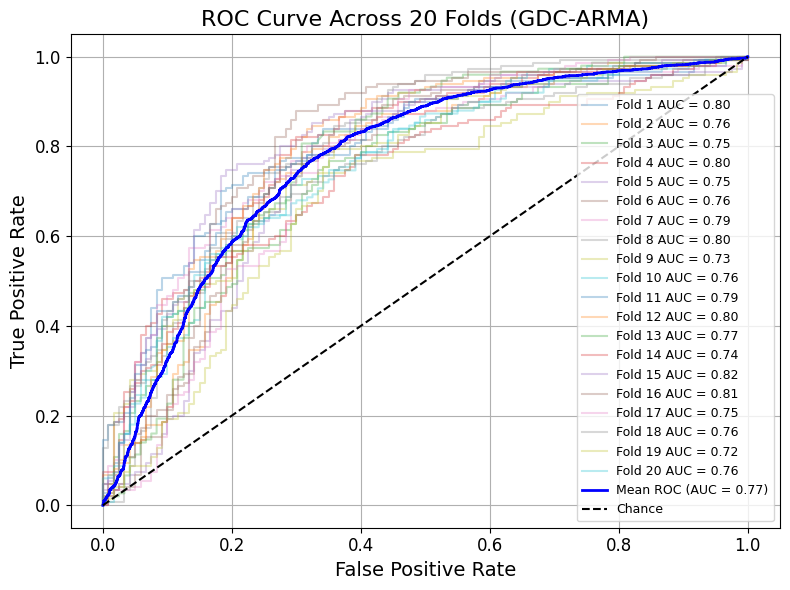

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (GDC-ARMA)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

Alpha = 0.1

===== Running 20-Fold CV for NONE Graph =====

Training fold 1 for none graph
Fold 1: Acc=0.7444 | Prec=0.7793 | Rec=0.7533 | F1=0.7661 | Loss=0.7141

Training fold 2 for none graph
Fold 2: Acc=0.7815 | Prec=0.8013 | Rec=0.8067 | F1=0.8040 | Loss=0.6740

Training fold 3 for none graph
Fold 3: Acc=0.7407 | Prec=0.7632 | Rec=0.7733 | F1=0.7682 | Loss=0.7531

Training fold 4 for none graph
Fold 4: Acc=0.7704 | Prec=0.7857 | Rec=0.8067 | F1=0.7961 | Loss=0.7842

Training fold 5 for none graph
Fold 5: Acc=0.7370 | Prec=0.7232 | Rec=0.8533 | F1=0.7829 | Loss=1.2607

Training fold 6 for none graph
Fold 6: Acc=0.7222 | Prec=0.7737 | Rec=0.7067 | F1=0.7387 | Loss=0.8688

Training fold 7 for none graph
Fold 7: Acc=0.7370 | Prec=0.7762 | Rec=0.7400 | F1=0.7577 | Loss=0.8223

Training fold 8 for none graph
Fold 8: Acc=0.7667 | Prec=0.7458 | Rec=0.8800 | F1=0.8073 | Loss=0.6771

Training fold 9 for none graph
Fold 9: Acc=0.7185 | Prec=0.7891 | Rec=0.6733 | F1=0.7266 | Loss=1.0509

Training fold 10 for none graph
Fold 10: Acc=0.7481 | Prec=0.7440 | Rec=0.8333 | F1=0.7862 | Loss=0.8127

Training fold 11 for none graph
Fold 11: Acc=0.7481 | Prec=0.7971 | Rec=0.7333 | F1=0.7639 | Loss=0.7676

Training fold 12 for none graph
Fold 12: Acc=0.7667 | Prec=0.7605 | Rec=0.8467 | F1=0.8013 | Loss=0.7170

Training fold 13 for none graph
Fold 13: Acc=0.7630 | Prec=0.7622 | Rec=0.8333 | F1=0.7962 | Loss=0.9042

Training fold 14 for none graph
Fold 14: Acc=0.6852 | Prec=0.7372 | Rec=0.6733 | F1=0.7038 | Loss=0.9857

Training fold 15 for none graph
Fold 15: Acc=0.7852 | Prec=0.7987 | Rec=0.8200 | F1=0.8092 | Loss=0.7314

Training fold 16 for none graph
Fold 16: Acc=0.7852 | Prec=0.7875 | Rec=0.8400 | F1=0.8129 | Loss=0.8936

Training fold 17 for none graph
Fold 17: Acc=0.7704 | Prec=0.7821 | Rec=0.8133 | F1=0.7974 | Loss=0.8070

Training fold 18 for none graph
Fold 18: Acc=0.7259 | Prec=0.7603 | Rec=0.7400 | F1=0.7500 | Loss=0.8185

Training fold 19 for none graph
Fold 19: Acc=0.7185 | Prec=0.7176 | Rec=0.8133 | F1=0.7625 | Loss=0.9752

Training fold 20 for none graph
Fold 20: Acc=0.7111 | Prec=0.7250 | Rec=0.7733 | F1=0.7484 | Loss=0.7496

==== NONE Graph 20-Fold Average Results ====
Avg Acc=0.7463 | Avg Prec=0.7655 | Avg Rec=0.7857 | Avg F1=0.7740 | Avg Loss=0.8384


===== Running 20-Fold CV for HEAT Graph =====

Training fold 1 for heat graph
Fold 1: Acc=0.7370 | Prec=0.7616 | Rec=0.7667 | F1=0.7641 | Loss=0.6316

Training fold 2 for heat graph
Fold 2: Acc=0.7444 | Prec=0.7613 | Rec=0.7867 | F1=0.7738 | Loss=0.7016

Training fold 3 for heat graph
Fold 3: Acc=0.6889 | Prec=0.7260 | Rec=0.7067 | F1=0.7162 | Loss=0.7164

Training fold 4 for heat graph
Fold 4: Acc=0.7852 | Prec=0.7949 | Rec=0.8267 | F1=0.8105 | Loss=0.6660

Training fold 5 for heat graph
Fold 5: Acc=0.7407 | Prec=0.7469 | Rec=0.8067 | F1=0.7756 | Loss=0.9634

Training fold 6 for heat graph
Fold 6: Acc=0.6667 | Prec=0.7500 | Rec=0.6000 | F1=0.6667 | Loss=0.7845

Training fold 7 for heat graph
Fold 7: Acc=0.7111 | Prec=0.7647 | Rec=0.6933 | F1=0.7273 | Loss=0.7392

Training fold 8 for heat graph
Fold 8: Acc=0.7630 | Prec=0.7529 | Rec=0.8533 | F1=0.8000 | Loss=0.6183

Training fold 9 for heat graph
Fold 9: Acc=0.6815 | Prec=0.7500 | Rec=0.6400 | F1=0.6906 | Loss=0.8625

Training fold 10 for heat graph
Fold 10: Acc=0.7111 | Prec=0.7250 | Rec=0.7733 | F1=0.7484 | Loss=0.7445

Training fold 11 for heat graph
Fold 11: Acc=0.7111 | Prec=0.7432 | Rec=0.7333 | F1=0.7383 | Loss=0.6692

Training fold 12 for heat graph
Fold 12: Acc=0.7556 | Prec=0.7877 | Rec=0.7667 | F1=0.7770 | Loss=0.6595

Training fold 13 for heat graph
Fold 13: Acc=0.7481 | Prec=0.7440 | Rec=0.8333 | F1=0.7862 | Loss=0.7671

Training fold 14 for heat graph
Fold 14: Acc=0.6741 | Prec=0.7246 | Rec=0.6667 | F1=0.6944 | Loss=0.8563

Training fold 15 for heat graph
Fold 15: Acc=0.7667 | Prec=0.7806 | Rec=0.8067 | F1=0.7934 | Loss=0.6641

Training fold 16 for heat graph
Fold 16: Acc=0.7704 | Prec=0.7895 | Rec=0.8000 | F1=0.7947 | Loss=0.7167

Training fold 17 for heat graph
Fold 17: Acc=0.6926 | Prec=0.7310 | Rec=0.7067 | F1=0.7186 | Loss=0.8170

Training fold 18 for heat graph
Fold 18: Acc=0.7111 | Prec=0.7466 | Rec=0.7267 | F1=0.7365 | Loss=0.7055

Training fold 19 for heat graph
Fold 19: Acc=0.7259 | Prec=0.7262 | Rec=0.8133 | F1=0.7673 | Loss=0.8590

Training fold 20 for heat graph
Fold 20: Acc=0.7000 | Prec=0.7041 | Rec=0.7933 | F1=0.7461 | Loss=0.7449

==== HEAT Graph 20-Fold Average Results ====
Avg Acc=0.7243 | Avg Prec=0.7506 | Avg Rec=0.7550 | Avg F1=0.7513 | Avg Loss=0.7444


===== Running 20-Fold CV for PPR Graph =====

Training fold 1 for ppr graph
Fold 1: Acc=0.7333 | Prec=0.7708 | Rec=0.7400 | F1=0.7551 | Loss=0.7448

Training fold 2 for ppr graph
Fold 2: Acc=0.6963 | Prec=0.7500 | Rec=0.6800 | F1=0.7133 | Loss=0.7789

Training fold 3 for ppr graph
Fold 3: Acc=0.6926 | Prec=0.7248 | Rec=0.7200 | F1=0.7224 | Loss=0.7641

Training fold 4 for ppr graph
Fold 4: Acc=0.7519 | Prec=0.7785 | Rec=0.7733 | F1=0.7759 | Loss=0.6947

Training fold 5 for ppr graph
Fold 5: Acc=0.7370 | Prec=0.7423 | Rec=0.8067 | F1=0.7732 | Loss=1.0826

Training fold 6 for ppr graph
Fold 6: Acc=0.6704 | Prec=0.7440 | Rec=0.6200 | F1=0.6764 | Loss=0.9293

Training fold 7 for ppr graph
Fold 7: Acc=0.7444 | Prec=0.7682 | Rec=0.7733 | F1=0.7708 | Loss=0.7432

Training fold 8 for ppr graph
Fold 8: Acc=0.7370 | Prec=0.7453 | Rec=0.8000 | F1=0.7717 | Loss=0.6932

Training fold 9 for ppr graph
Fold 9: Acc=0.6741 | Prec=0.7385 | Rec=0.6400 | F1=0.6857 | Loss=0.9195

Training fold 10 for ppr graph
Fold 10: Acc=0.7333 | Prec=0.7349 | Rec=0.8133 | F1=0.7722 | Loss=0.7635

Training fold 11 for ppr graph
Fold 11: Acc=0.7222 | Prec=0.7622 | Rec=0.7267 | F1=0.7440 | Loss=0.7752

Training fold 12 for ppr graph
Fold 12: Acc=0.7630 | Prec=0.7654 | Rec=0.8267 | F1=0.7949 | Loss=0.6523

Training fold 13 for ppr graph
Fold 13: Acc=0.7259 | Prec=0.7317 | Rec=0.8000 | F1=0.7643 | Loss=0.7897

Training fold 14 for ppr graph
Fold 14: Acc=0.6852 | Prec=0.7305 | Rec=0.6867 | F1=0.7079 | Loss=0.9356

Training fold 15 for ppr graph
Fold 15: Acc=0.7667 | Prec=0.8222 | Rec=0.7400 | F1=0.7789 | Loss=0.7005

Training fold 16 for ppr graph
Fold 16: Acc=0.7741 | Prec=0.7947 | Rec=0.8000 | F1=0.7973 | Loss=0.7554

Training fold 17 for ppr graph
Fold 17: Acc=0.6704 | Prec=0.6943 | Rec=0.7267 | F1=0.7101 | Loss=0.8997

Training fold 18 for ppr graph
Fold 18: Acc=0.7185 | Prec=0.7569 | Rec=0.7267 | F1=0.7415 | Loss=0.7515

Training fold 19 for ppr graph
Fold 19: Acc=0.7000 | Prec=0.7170 | Rec=0.7600 | F1=0.7379 | Loss=0.8505

Training fold 20 for ppr graph
Fold 20: Acc=0.7148 | Prec=0.7239 | Rec=0.7867 | F1=0.7540 | Loss=0.7978

==== PPR Graph 20-Fold Average Results ====
Avg Acc=0.7206 | Avg Prec=0.7498 | Avg Rec=0.7473 | Avg F1=0.7474 | Avg Loss=0.8011


When alpha = 0

===== Running 20-Fold CV for NONE Graph =====

Training fold 1 for none graph
Fold 1: Acc=0.7481 | Prec=0.7500 | Rec=0.8200 | F1=0.7834 | Loss=0.6723

Training fold 2 for none graph
Fold 2: Acc=0.7556 | Prec=0.7763 | Rec=0.7867 | F1=0.7815 | Loss=0.7413

Training fold 3 for none graph
Fold 3: Acc=0.7111 | Prec=0.7500 | Rec=0.7200 | F1=0.7347 | Loss=0.7462

Training fold 4 for none graph
Fold 4: Acc=0.7778 | Prec=0.7961 | Rec=0.8067 | F1=0.8013 | Loss=0.6804

Training fold 5 for none graph
Fold 5: Acc=0.7222 | Prec=0.7273 | Rec=0.8000 | F1=0.7619 | Loss=1.1600

Training fold 6 for none graph
Fold 6: Acc=0.7000 | Prec=0.7674 | Rec=0.6600 | F1=0.7097 | Loss=0.8683

Training fold 7 for none graph
Fold 7: Acc=0.7111 | Prec=0.7500 | Rec=0.7200 | F1=0.7347 | Loss=0.7705

Training fold 8 for none graph
Fold 8: Acc=0.7593 | Prec=0.7515 | Rec=0.8467 | F1=0.7962 | Loss=0.6582

Training fold 9 for none graph
Fold 9: Acc=0.7037 | Prec=0.7734 | Rec=0.6600 | F1=0.7122 | Loss=0.9365

Training fold 10 for none graph
Fold 10: Acc=0.7519 | Prec=0.7485 | Rec=0.8333 | F1=0.7886 | Loss=0.7646

Training fold 11 for none graph
Fold 11: Acc=0.7556 | Prec=0.8043 | Rec=0.7400 | F1=0.7708 | Loss=0.7323

Training fold 12 for none graph
Fold 12: Acc=0.7407 | Prec=0.7469 | Rec=0.8067 | F1=0.7756 | Loss=0.7207

Training fold 13 for none graph
Fold 13: Acc=0.7444 | Prec=0.7368 | Rec=0.8400 | F1=0.7850 | Loss=0.8787

Training fold 14 for none graph
Fold 14: Acc=0.7074 | Prec=0.7483 | Rec=0.7133 | F1=0.7304 | Loss=0.9001

Training fold 15 for none graph
Fold 15: Acc=0.7778 | Prec=0.8000 | Rec=0.8000 | F1=0.8000 | Loss=0.6932

Training fold 16 for none graph
Fold 16: Acc=0.7963 | Prec=0.7987 | Rec=0.8467 | F1=0.8220 | Loss=0.8237

Training fold 17 for none graph
Fold 17: Acc=0.7148 | Prec=0.7483 | Rec=0.7333 | F1=0.7407 | Loss=0.8254

Training fold 18 for none graph
Fold 18: Acc=0.7185 | Prec=0.7500 | Rec=0.7400 | F1=0.7450 | Loss=0.7692

Training fold 19 for none graph
Fold 19: Acc=0.7037 | Prec=0.7083 | Rec=0.7933 | F1=0.7484 | Loss=0.9723

Training fold 20 for none graph
Fold 20: Acc=0.7148 | Prec=0.7186 | Rec=0.8000 | F1=0.7571 | Loss=0.7080

==== NONE Graph 20-Fold Average Results ====
Avg Acc=0.7357 | Avg Prec=0.7575 | Avg Rec=0.7733 | Avg F1=0.7640 | Avg Loss=0.8011


===== Running 20-Fold CV for HEAT Graph =====

Training fold 1 for heat graph
Fold 1: Acc=0.7556 | Prec=0.7838 | Rec=0.7733 | F1=0.7785 | Loss=0.6531

Training fold 2 for heat graph
Fold 2: Acc=0.7407 | Prec=0.7564 | Rec=0.7867 | F1=0.7712 | Loss=0.6895

Training fold 3 for heat graph
Fold 3: Acc=0.7148 | Prec=0.7664 | Rec=0.7000 | F1=0.7317 | Loss=0.6986

Training fold 4 for heat graph
Fold 4: Acc=0.7667 | Prec=0.8042 | Rec=0.7667 | F1=0.7850 | Loss=0.6652

Training fold 5 for heat graph
Fold 5: Acc=0.7222 | Prec=0.7273 | Rec=0.8000 | F1=0.7619 | Loss=0.9761

Training fold 6 for heat graph
Fold 6: Acc=0.6741 | Prec=0.7541 | Rec=0.6133 | F1=0.6765 | Loss=0.8072

Training fold 7 for heat graph
Fold 7: Acc=0.7333 | Prec=0.7826 | Rec=0.7200 | F1=0.7500 | Loss=0.6778

Training fold 8 for heat graph
Fold 8: Acc=0.7630 | Prec=0.7688 | Rec=0.8200 | F1=0.7935 | Loss=0.6352

Training fold 9 for heat graph
Fold 9: Acc=0.7000 | Prec=0.7594 | Rec=0.6733 | F1=0.7138 | Loss=0.8662

Training fold 10 for heat graph
Fold 10: Acc=0.7296 | Prec=0.7452 | Rec=0.7800 | F1=0.7622 | Loss=0.7376

Training fold 11 for heat graph
Fold 11: Acc=0.7222 | Prec=0.7660 | Rec=0.7200 | F1=0.7423 | Loss=0.6863

Training fold 12 for heat graph
Fold 12: Acc=0.7370 | Prec=0.7516 | Rec=0.7867 | F1=0.7687 | Loss=0.6806

Training fold 13 for heat graph
Fold 13: Acc=0.7481 | Prec=0.7531 | Rec=0.8133 | F1=0.7821 | Loss=0.7635

Training fold 14 for heat graph
Fold 14: Acc=0.6519 | Prec=0.7121 | Rec=0.6267 | F1=0.6667 | Loss=0.8989

Training fold 15 for heat graph
Fold 15: Acc=0.7741 | Prec=0.7987 | Rec=0.7933 | F1=0.7960 | Loss=0.6744

Training fold 16 for heat graph
Fold 16: Acc=0.7815 | Prec=0.7826 | Rec=0.8400 | F1=0.8103 | Loss=0.7312

Training fold 17 for heat graph
Fold 17: Acc=0.7037 | Prec=0.7108 | Rec=0.7867 | F1=0.7468 | Loss=0.8128

Training fold 18 for heat graph
Fold 18: Acc=0.7148 | Prec=0.7450 | Rec=0.7400 | F1=0.7425 | Loss=0.6887

Training fold 19 for heat graph
Fold 19: Acc=0.7074 | Prec=0.7126 | Rec=0.7933 | F1=0.7508 | Loss=0.8096

Training fold 20 for heat graph
Fold 20: Acc=0.7111 | Prec=0.7278 | Rec=0.7667 | F1=0.7468 | Loss=0.7080

==== HEAT Graph 20-Fold Average Results ====
Avg Acc=0.7276 | Avg Prec=0.7554 | Avg Rec=0.7550 | Avg F1=0.7539 | Avg Loss=0.7430


===== Running 20-Fold CV for PPR Graph =====

Training fold 1 for ppr graph
Fold 1: Acc=0.7296 | Prec=0.7452 | Rec=0.7800 | F1=0.7622 | Loss=0.6961

Training fold 2 for ppr graph
Fold 2: Acc=0.7222 | Prec=0.7517 | Rec=0.7467 | F1=0.7492 | Loss=0.7449

Training fold 3 for ppr graph
Fold 3: Acc=0.6852 | Prec=0.7481 | Rec=0.6533 | F1=0.6975 | Loss=0.7643

Training fold 4 for ppr graph
Fold 4: Acc=0.7444 | Prec=0.7718 | Rec=0.7667 | F1=0.7692 | Loss=0.7219

Training fold 5 for ppr graph
Fold 5: Acc=0.7222 | Prec=0.7419 | Rec=0.7667 | F1=0.7541 | Loss=1.0361

Training fold 6 for ppr graph
Fold 6: Acc=0.6778 | Prec=0.7603 | Rec=0.6133 | F1=0.6790 | Loss=0.9123

Training fold 7 for ppr graph
Fold 7: Acc=0.7148 | Prec=0.7626 | Rec=0.7067 | F1=0.7336 | Loss=0.7426

Training fold 8 for ppr graph
Fold 8: Acc=0.7481 | Prec=0.7531 | Rec=0.8133 | F1=0.7821 | Loss=0.6832

Training fold 9 for ppr graph
Fold 9: Acc=0.6852 | Prec=0.7444 | Rec=0.6600 | F1=0.6996 | Loss=0.9512

Training fold 10 for ppr graph
Fold 10: Acc=0.6963 | Prec=0.7152 | Rec=0.7533 | F1=0.7338 | Loss=0.8570

Training fold 11 for ppr graph
Fold 11: Acc=0.7407 | Prec=0.7817 | Rec=0.7400 | F1=0.7603 | Loss=0.6651

Training fold 12 for ppr graph
Fold 12: Acc=0.7296 | Prec=0.7584 | Rec=0.7533 | F1=0.7559 | Loss=0.7262

Training fold 13 for ppr graph
Fold 13: Acc=0.7444 | Prec=0.7455 | Rec=0.8200 | F1=0.7810 | Loss=0.8406

Training fold 14 for ppr graph
Fold 14: Acc=0.6556 | Prec=0.7244 | Rec=0.6133 | F1=0.6643 | Loss=0.9891

Training fold 15 for ppr graph
Fold 15: Acc=0.7519 | Prec=0.7785 | Rec=0.7733 | F1=0.7759 | Loss=0.7072

Training fold 16 for ppr graph
Fold 16: Acc=0.7852 | Prec=0.7949 | Rec=0.8267 | F1=0.8105 | Loss=0.7726

Training fold 17 for ppr graph
Fold 17: Acc=0.7111 | Prec=0.7250 | Rec=0.7733 | F1=0.7484 | Loss=0.8411

Training fold 18 for ppr graph
Fold 18: Acc=0.7111 | Prec=0.7466 | Rec=0.7267 | F1=0.7365 | Loss=0.7301

Training fold 19 for ppr graph
Fold 19: Acc=0.6778 | Prec=0.7114 | Rec=0.7067 | F1=0.7090 | Loss=0.9294

Training fold 20 for ppr graph
Fold 20: Acc=0.6926 | Prec=0.7055 | Rec=0.7667 | F1=0.7348 | Loss=0.7987

==== PPR Graph 20-Fold Average Results ====
Avg Acc=0.7163 | Avg Prec=0.7483 | Avg Rec=0.7380 | Avg F1=0.7418 | Avg Loss=0.8055


In [ ]:
# results = {}
# for name, d in zip(['none', 'heat', 'ppr'], [data_none, data_heat, data_ppr]):
#     results[name] = train_eval(d, seeds=50)

# for name, best_dict in results.items():
#     boots_series = sns.algorithms.bootstrap(best_dict['test_acc'], func=np.mean, n_boot=1000)
#     ci = np.max(np.abs(sns.utils.ci(boots_series, 95) - np.mean(best_dict['test_acc'])))
#     mean_acc = np.mean(best_dict['test_acc'])
#     print(f"{name}: Mean accuracy: {100*mean_acc:.2f} ± {100*ci:.2f}%")